## **Balancing a Pole on a Cart**
### 24S2 SC3000/CZ3005 Assignment 1
---
### Team Members
- Toh Jun Sheng
- Isaac Wong Jia Kai
- Tio Sher Min
---
### Contribution

#### Training the RL Agent

#### Task 1: Development of an RL Agent


#### Task 2: Demonstrate the effectiveness of the RL agent

#### Task 3: Render one episode played by the developed RL agent

#### Task 4: Format the Jupyter notebook
---

## Installing dependencies:

In [1]:
!pip install gym pyvirtualdisplay 
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install pygame gymnasium[classic-control] pyvirtualdisplay
!pip install --upgrade setuptools 
!pip install moviepy

zsh:1: no matches found: gymnasium[classic-control]


## Importing dependencies and define helper functions

In [2]:
import gym
from gym import logger as gymlogger
from gym.wrappers import RecordVideo
gymlogger.set_level(40) #error only
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")

## Tutorial: Loading CartPole environment

In [3]:
env = gym.make("CartPole-v1")

We can check the action and observation space of this environment. Discrete(2) means that there are two valid discrete actions: 0 & 1.

In [4]:
print(env.action_space)

Discrete(2)


The observation space is given below. The first two arrays define the min and max values of the 4 observed values, corresponding to cart position, velocity and pole angle, angular velocity.

In [5]:
print(env.observation_space)

Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)


We call each round of the pole-balancing game an "episode". At the start of each episode, make sure the environment is reset, which chooses a random initial state, e.g., pole slightly tilted to the right. This initialization can be achieved by the code below, which returns the observation of the initial state.

In [6]:
observation = env.reset()
print("Initial observations:", observation)

Initial observations: (array([-0.03199831,  0.00361315, -0.00932821, -0.04153002], dtype=float32), {})


For the CartPole environment, there are two possible actions: 0 for pushing to the left and 1 for pushing to the right. For example, we can push the cart to the left using code below, which returns the new observation, the current reward, an indicator of whether the game ends, and some additional information (not used in this project). For CartPole, the game ends when the pole is significantly tilted or you manage to balance the pole for 500 steps. You get exactly 1 reward for each step before the game ends (i.e., max cumulative reward is 500).

In [7]:
observation, reward, terminated, truncated, info = env.step(0)
done = terminated or truncated

print("New observations after choosing action 0:", observation)
print("Reward for this step:", reward)
print("Is this round done?", done)

New observations after choosing action 0: [-0.03192605 -0.19137381 -0.01015881  0.24819523]
Reward for this step: 1.0
Is this round done? False


Now we can play a full round of the game using a naive strategy (always choosing action 0), and show the cumulative reward in the round. Note that reward returned by env.step(*) corresponds to the reward for current step. So we have to accumulate the reward for each step. Clearly, the naive strategy performs poorly by surviving only a dozen of steps.

In [8]:
observation, _ = env.reset()
cumulative_reward = 0
done = False

while not done:
    observation, reward, terminated, truncated, info = env.step(0)
    done = terminated or truncated
    cumulative_reward += reward

print("Cumulative reward for this round:", cumulative_reward)

Cumulative reward for this round: 9.0


## Solution 1: Q-Learning Agent 

<h3> Preparations before training the agent

In [9]:
# Initialize environment
env = gym.make("CartPole-v1")

<h5> Q-learning works with finite (discrete) state spaces, but CartPole’s state is continuous, meaning there are infinite possible states. <br>
The agent can’t store Q-values for infinite states, so we must discretize the state space into bins. </h5>


In [10]:
# Discretize the continuous observation space into bins
state_bins = [
    np.linspace(-4.8, 4.8, 25),     # Cart Position
    np.linspace(-5, 5, 25),         # Cart Velocity
    np.linspace(-0.418, 0.418, 25), # Pole Angle
    np.linspace(-5, 5, 25)          # Pole Angular Velocity
]

# Function to discretize a continuous state
def get_discrete_state(state):
    discrete_state = []
    for s, bins in zip(state, state_bins):
        index = np.digitize(s, bins)
        index = min(max(index, 0), len(bins))  # Clip to valid range
        discrete_state.append(index)
    return tuple(discrete_state)

# Q-table initialization 
q_table = np.zeros([len(b) + 1 for b in state_bins] + [env.action_space.n])  # All entries initialized as 0 

<h5> The observations for the current continuous state will be saved into the respective bins indicated in the discrete state tuple. These bins shall make up the q-table, a multi-dimensional table storing the action-value estimates for each discrete state-action pair.

In [11]:
# Check initial state
observation, _ = env.reset()
discrete_obs = get_discrete_state(observation)
print("Continuous state:", observation)
print("Discrete state:", tuple(int(x) for x in discrete_obs))

Continuous state: [ 0.02464904 -0.042399   -0.04170468  0.03333934]
Discrete state: (13, 12, 11, 13)


<h4> Next, we define the hyperparameters that will be used by the Q-Learning agent

In [12]:
# Hyperparameters
alpha = 0.1            # Learning rate (Alpha)
gamma = 0.99           # Discount factor (Gamma)
epsilon = 1.0          # Initial exploration rate
epsilon_min = 0.05
episodes = 10000       # Training episodes

<h4> The functionalities of the agent are as such: 

- For each step during an episode, a random number between 0 and 1 will be generated and compared with the current epsilon value
    - if the value is smaller than epsilon, a random action shall be taken. Else a greedy action will be taken based on the q_table


In [13]:
# Epsilon-greedy action selection
def epsilon_greedy_action(state, epsilon):
    if np.random.random() < epsilon:
        return env.action_space.sample()  # Explore
    else:
        return np.argmax(q_table[state])  # Exploit


def q_policy_agent(observation):
    discrete_state = get_discrete_state(observation)
    return np.argmax(q_table[discrete_state])

<h4> Now we shall proceed to training the agent with 10,000 episodes in order to fill the q_table </h4> 
<h5> Note: This will take approximately 90 secs to run </h5>

Episode 500, Reward: 23.222, Epsilon: 0.941
Episode 1000, Reward: 24.856, Epsilon: 0.881
Episode 1500, Reward: 27.684, Epsilon: 0.822
Episode 2000, Reward: 31.896, Epsilon: 0.762
Episode 2500, Reward: 37.77, Epsilon: 0.703
Episode 3000, Reward: 48.692, Epsilon: 0.644
Episode 3500, Reward: 60.312, Epsilon: 0.584
Episode 4000, Reward: 71.52, Epsilon: 0.525
Episode 4500, Reward: 87.686, Epsilon: 0.466
Episode 5000, Reward: 114.762, Epsilon: 0.406
Episode 5500, Reward: 136.348, Epsilon: 0.347
Episode 6000, Reward: 145.87, Epsilon: 0.287
Episode 6500, Reward: 197.632, Epsilon: 0.228
Episode 7000, Reward: 194.318, Epsilon: 0.169
Episode 7500, Reward: 274.838, Epsilon: 0.109
Episode 8000, Reward: 210.98, Epsilon: 0.050
Episode 8500, Reward: 178.242, Epsilon: 0.050
Episode 9000, Reward: 188.112, Epsilon: 0.050
Episode 9500, Reward: 171.296, Epsilon: 0.050


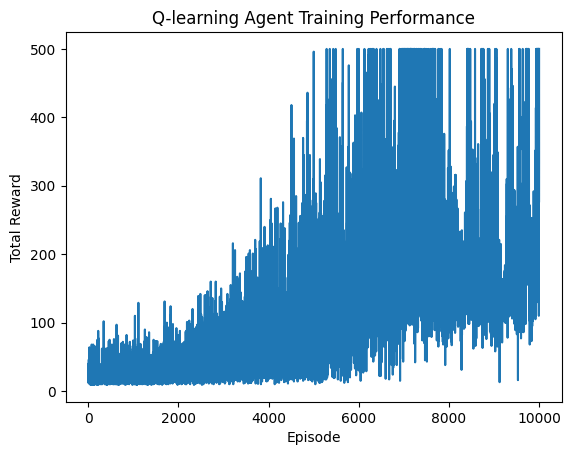

In [14]:
# Training
rewards = []
total_mean_reward = 0
epsilon_decay = (epsilon-epsilon_min)/(episodes*0.8)

for episode in range(episodes):
    state = get_discrete_state(env.reset()[0])
    done = False
    total_reward = 0

    while not done:
        action = epsilon_greedy_action(state, epsilon)

        next_obs, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        next_state = get_discrete_state(next_obs)

        # Q-learning update rule
        best_next_action = np.argmax(q_table[next_state])
        td_target = reward + gamma * q_table[next_state][best_next_action]
        td_error = td_target - q_table[state][action]
        q_table[state][action] += alpha * td_error

        state = next_state
        total_reward += reward

    rewards.append(total_reward)
    total_mean_reward += total_reward

    # Epsilon decay
    if epsilon > epsilon_min:
        epsilon -= epsilon_decay

    # Print progress
    if episode % 500 == 0 and episode != 0:
        print(f"Episode {episode}, Reward: {total_mean_reward/500}, Epsilon: {epsilon:.3f}")
        total_mean_reward = 0

# Plotting cumulative reward
plt.plot(rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Q-learning Agent Training Performance")
plt.show()

<h4> By allowing epsilon to decay linearly such that the min value is reached after around 8000 episodes, we can observe the epsilon-greedy process at work, slowly shifting from more exploration to more exploitation. <br>
Since epsilon starts at 1 and gradually decreases over time, in early episodes, the agent explores more (choosing a random action frequently). As epsilon gets smaller, the agent exploits more (choosing the best-known action more often).

- Epsilon only decreases if the agent's reward is improving, encouraging exploration when needed. 
- It stops decreasing at 0.05, ensuring the agent never stops exploring completely.

<h2> <b> Task 1 </b> </h2> 

In [15]:
# === Task 1 Code ===
observation = env.reset()[0]
discrete_obs = get_discrete_state(observation) 
action = q_policy_agent(observation)

print("Continuous state:", observation)
print("Discrete state:", tuple(int(x) for x in discrete_obs)) 
print("Chosen action:", action)

Continuous state: [0.03466251 0.03494104 0.02984545 0.01951109]
Discrete state: (13, 13, 13, 13)
Chosen action: 1


<h4> As we can see, in this particular observation state, the best action found by the agent after training is 0 (left)

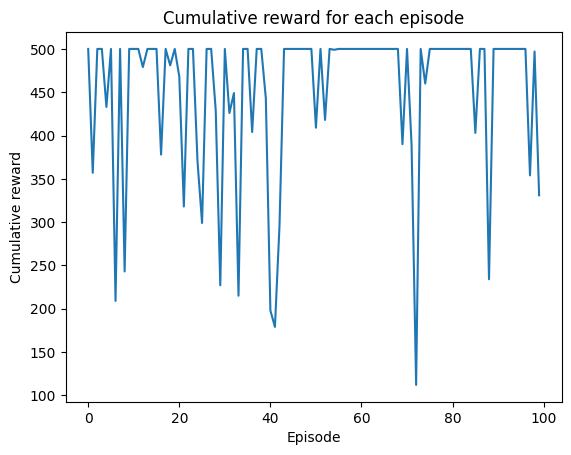

Average cumulative reward: 452.97
Is my agent good enough? True
Best episode index: 0
Best reward: 500.0


In [16]:
# === Task 2: Evaluation of Trained Agent ===

epsilon = 0.0
episode_results = []
best_episode_index = -1
best_reward = 0

# Use unwrapped environment for evaluation (faster)
env = gym.make("CartPole-v1", render_mode="rgb_array")

for episode in range(100):
    obs = env.reset(seed=episode)[0]  # fixed seed = reproducible episode
    state = get_discrete_state(obs)
    done = False
    total_reward = 0

    while not done:
        action = epsilon_greedy_action(state, epsilon)
        next_obs, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        state = get_discrete_state(next_obs)
        total_reward += reward

    episode_results.append(total_reward)

    if total_reward > best_reward:
        best_reward = total_reward
        best_episode_index = episode

env.close()

# === Plot rewards ===
plt.plot(episode_results)
plt.title('Cumulative reward for each episode')
plt.ylabel('Cumulative reward')
plt.xlabel('Episode')
plt.show()

# === Print result ===
print("Average cumulative reward:", np.mean(episode_results))
print("Is my agent good enough?", np.mean(episode_results) > 195)
print("Best episode index:", best_episode_index)
print("Best reward:", best_reward)


In [ ]:
# === Task 3: Record and Replay the Best Episode ===

# Create a new environment that records the best episode
env = RecordVideo(
    gym.make("CartPole-v1", render_mode="rgb_array"),
    video_folder="video",
    episode_trigger=lambda e: True
)

# Reset with the same seed used in Task 2
observation = env.reset(seed=best_episode_index)[0]
done = False

while not done:
    action = q_policy_agent(observation)
    observation, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated

env.close()

# === Display recorded video ===
show_video()


In [18]:
# Check initial state
observation, _ = env.reset()
discrete_obs = get_discrete_state(observation)
print("Continuous state:", observation)
print("Discrete state:", discrete_obs)

Continuous state: [ 0.01149031  0.00682835 -0.02132133  0.00545115]
Discrete state: (13, 13, 12, 13)


## Alternative Solution: DQN
We examine how good DQN is in order to achieve a relatively good average reward 

In [19]:
from stable_baselines3 import DQN

In [20]:
# Initialize environment
env = gym.make("CartPole-v1")

# DQN with default parameters
dqn_model = DQN("MlpPolicy", env, seed = 42, verbose=1)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


In [21]:
# Training
def train_dqn_model(model, total_timesteps=1000000):
    print("Training DQN model...")
    model.learn(total_timesteps=total_timesteps)
    model.save("dqn_cartpole")
    print("DQN model trained and saved.")
    return model

dqn_model = train_dqn_model(dqn_model, total_timesteps=1000000)

Training DQN model...
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 23       |
|    ep_rew_mean      | 23       |
|    exploration_rate | 0.999    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 17103    |
|    time_elapsed     | 0        |
|    total_timesteps  | 92       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 24.9     |
|    ep_rew_mean      | 24.9     |
|    exploration_rate | 0.998    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 2182     |
|    time_elapsed     | 0        |
|    total_timesteps  | 199      |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.522    |
|    n_updates        | 24       |
----------------------------------
----------------------------------
| rollout/            |          

## **Task 1**

In [22]:
# === Task 1 Code ===
observation = env.reset()[0]
action, _states = dqn_model.predict(observation)

print("Continuous state:", observation)
print("Chosen action:", action)

Continuous state: [-0.03754818 -0.00819647  0.03173226  0.03014408]
Chosen action: 0


## **Task 2**

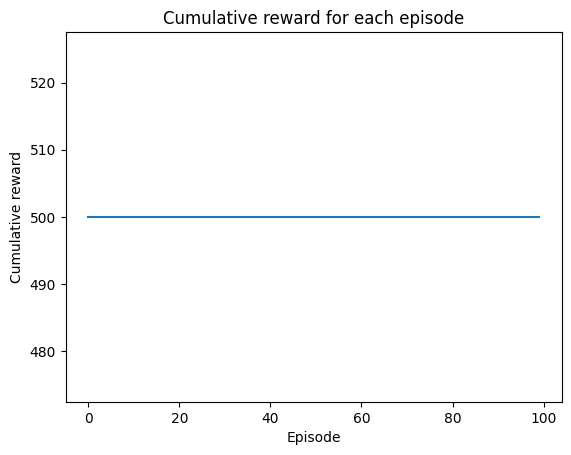

Average cumulative reward: 500.0
Is my agent good enough? True
Best episode index: 0
Best reward: 500.0


In [23]:
# === Task 2: Evaluation of Trained Agent ===

episode_results = []
best_episode_index = -1
best_reward = 0

# Use unwrapped environment for evaluation (faster)
env = gym.make("CartPole-v1", render_mode="rgb_array")

for episode in range(100):
    obs = env.reset(seed=episode)[0]
    done = False
    total_reward = 0

    while not done:
        action, _ = dqn_model.predict(obs, deterministic = True)
        obs, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        total_reward += reward

    episode_results.append(total_reward)

    if total_reward > best_reward:
        best_reward = total_reward
        best_episode_index = episode

env.close()

# === Plot rewards ===
plt.plot(episode_results)
plt.title('Cumulative reward for each episode')
plt.ylabel('Cumulative reward')
plt.xlabel('Episode')
plt.show()

# === Print result ===
print("Average cumulative reward:", np.mean(episode_results))
print("Is my agent good enough?", np.mean(episode_results) > 195)
print("Best episode index:", best_episode_index)
print("Best reward:", best_reward)

<h4> As we can see from the above, DQN is able to achieve a higher average cumulative reward and more stable performance. Q-learning requires discretizing CartPole's state spaces (continuous). However, DQN can work with infinite (continuous) state spaces directly, making it well-suited for environments like CartPole. </h4>